### Module import

In [8]:
!pip install opencv-python

In [2]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from gradcam_vis import visualize_cam, Normalize, GradCAM, GradCAMpp

### Load image

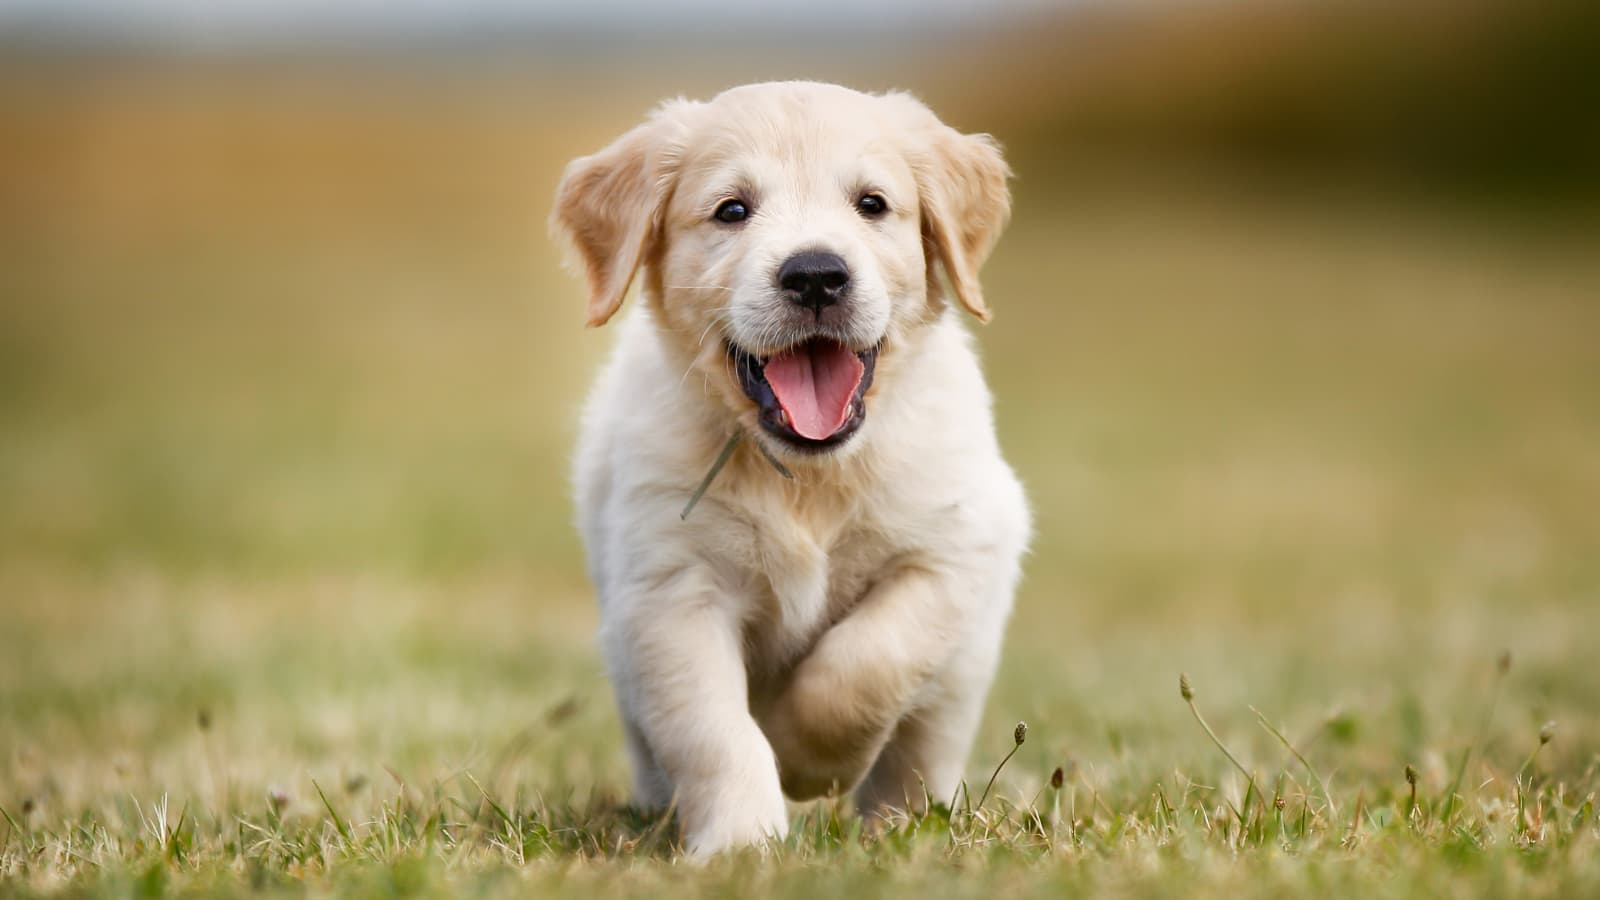

In [3]:
img_dir = ''
img_name = 'dog.jpeg'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

### preprocess image

In [4]:
pil_img = pil_img.convert('RGB')
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255)
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

ipykernel_launcher:3: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
/home/jindwang/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/jindwang/mine/code/ActivationMapVisualization/gradcam_vis/utils_grad.py:204: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_l

### Load torchvision models and make model dictionaries

In [5]:
resnet = models.resnet18(pretrained=True)
resnet.eval()
cam_dict = dict()
resnet_model_dict = dict(type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]


saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [6]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask.cpu(), torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images = make_grid(torch.cat(images, 0), nrow=5)

### Save and show results 

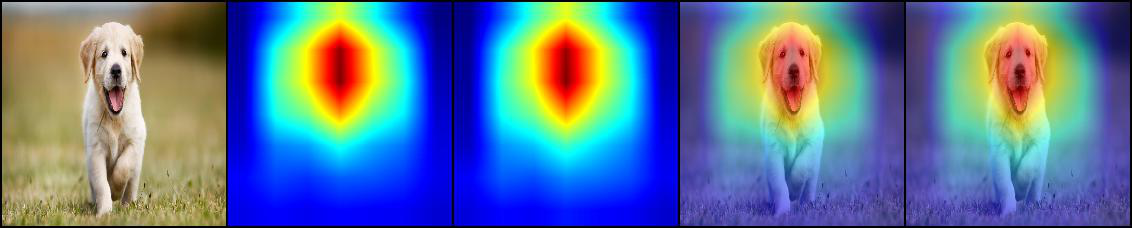

In [7]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)